In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from statsmodels.tsa.stattools import adfuller
sns.set_theme(style='darkgrid')

In [2]:
from data import get_price_data
from backtest import backtest_strat
from helpers import resume_backtest, performance_plot, annual_alpha_plot, price_to_perf, correlation, \
                    pred_to_perf, prob_to_pred, prob_to_pred_2
from test import get_training_processed_data
from sklearn.model_selection import train_test_split

In [142]:
indices_price = pd.read_excel('data/indices_price_SPI.xlsx', index_col=0, skiprows=[0, 1, 2, 3, 5, 6])
indices_price.to_csv('data/prices.csv')
indices_price.head()

,SPI Index,SPI19 Index,SPI20 Index,SPI21 Index
1996-01-03,2172.31,2170.14,3384.5,2208.62
1996-01-04,2182.67,2184.72,3395.8,2219.26
1996-01-05,2175.09,2181.00,3376.1,2208.69
1996-01-08,2176.68,2194.96,3368.1,2206.46
1996-01-09,2174.13,2204.00,3361.5,2201.63


In [3]:
indices_price = pd.read_csv('data/prices.csv', index_col=0, parse_dates=True)
print('Tickers :', list(indices_price.columns))
indices_price.head()

Tickers : ['SPI Index', 'SPI19 Index', 'SPI20 Index', 'SPI21 Index']


,SPI Index,SPI19 Index,SPI20 Index,SPI21 Index
1996-01-03,2172.31,2170.14,3384.5,2208.62
1996-01-04,2182.67,2184.72,3395.8,2219.26
1996-01-05,2175.09,2181.00,3376.1,2208.69
1996-01-08,2176.68,2194.96,3368.1,2206.46
1996-01-09,2174.13,2204.00,3361.5,2201.63


In [4]:
price, bench_price, df_X = get_price_data()
daily_returns = price.pct_change().shift(1)

In [52]:
ads_input = bench_price.rolling(5).apply(lambda x: np.log(x[-1] / x[0]) / len(x)).rolling(42).apply(lambda x: adfuller(x)[0])
ads_mean_input = adfuller(bench_price.rolling(5).apply(lambda x: np.log(x[-1] / x[0]) / len(x)).rolling(42).mean().dropna())[0]

In [53]:
print('ADS within each sample', ads_input.mean())
print('ADS between each sample', ads_mean_input)

ADS within each sample -2.551167272569375
ADS between each sample -11.569187698386589


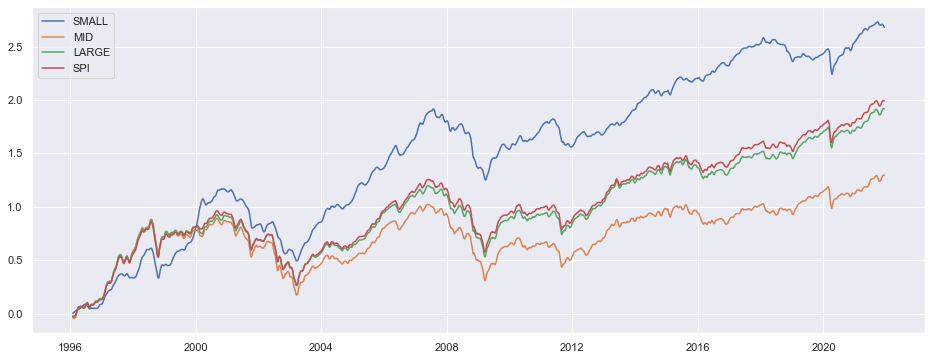

In [7]:
fig, ax = plt.subplots(figsize=(16,6))
data_plot = np.log((pd.concat([price, bench_price.rename('SPI')], axis=1).pct_change() + 1).cumprod().rolling(20).mean())
sns.lineplot(data=data_plot, dashes=False)
plt.show()

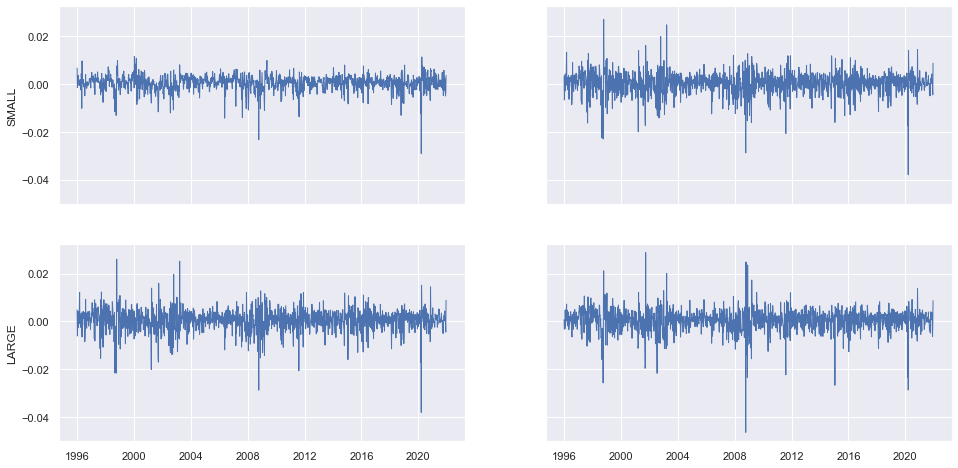

In [19]:
fix, axs = plt.subplots(2, 2, figsize=(16, 8), sharex=True, sharey=True)
axs = axs.ravel()

weekly_returns = pd.concat([price, bench_price], axis=1).pct_change().resample('W').mean()
for i, ticker in enumerate(weekly_returns.columns):
    sns.lineplot(ax=axs[i], data=weekly_returns[ticker], lw=1)

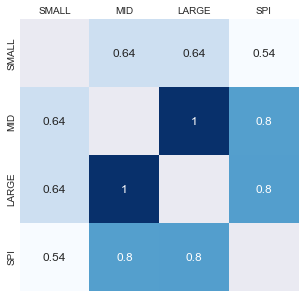

In [20]:
corr = pd.concat([price, bench_price], axis=1).pct_change().resample('W').mean().corr().round(4)

fig, ax = plt.subplots(figsize=(5,5))
mask = np.identity(len(corr))
sns.heatmap(data=corr, annot=True, cmap='Blues', cbar=False, mask=mask, annot_kws=dict(size=12))
ax.tick_params(axis='both', which='major', labelsize=10, labelbottom=False, labeltop=True, length=0)
plt.show()

In [21]:
rebalance_freq = 'W-FRI'
returns = price.pct_change().shift(1).resample(rebalance_freq).agg(lambda x: (x + 1).prod() - 1)
best_pred = returns.rank(axis=1).replace({1: 0., 2: 0., 3: 1.}).shift(-1)

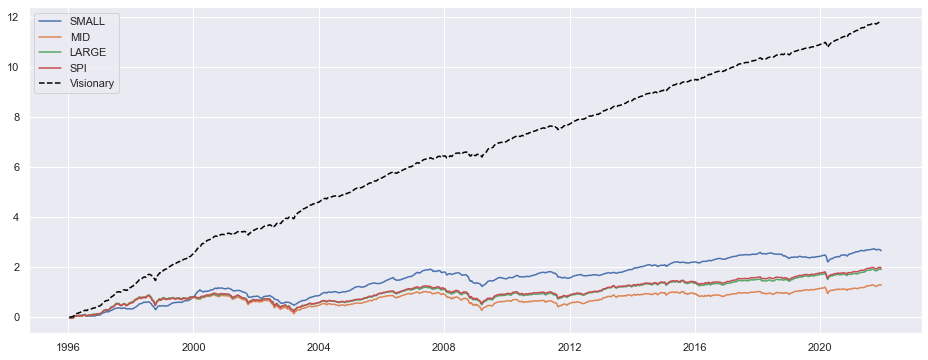

In [22]:
fig, ax = plt.subplots(figsize=(16,6))
best_perf = np.log(pred_to_perf(best_pred, daily_returns=daily_returns).rolling(10).mean())
data_plot = np.log((pd.concat([price, bench_price.rename('SPI')], axis=1).pct_change() + 1).reindex(best_perf.index).cumprod().rolling(10).mean())
sns.lineplot(data=data_plot, dashes=False)
sns.lineplot(data=best_perf, color='black', linestyle='--', label='Visionary')
plt.legend()
plt.show()

In [23]:
data_stats = pd.concat([price, bench_price], axis=1)
data_annual_ret = data_stats.pct_change().mean() * 252 * 100
data_annual_std = data_stats.pct_change().std() * np.sqrt(252) * 100
data_annual_sharpe = data_annual_ret.div(data_annual_std)
data_stats = pd.concat([data_annual_ret, data_annual_std, data_annual_sharpe], axis=1)
data_stats.columns = ['Annualized average return', 'Annualized Std', 'Sharpe Ratio']
data_stats.round(2)

,Annualized average return,Annualized Std,Sharpe Ratio
SMALL,10.44,9.86,1.06
MID,6.53,18.13,0.36
LARGE,8.82,18.00,0.49
SPI,8.91,17.03,0.52


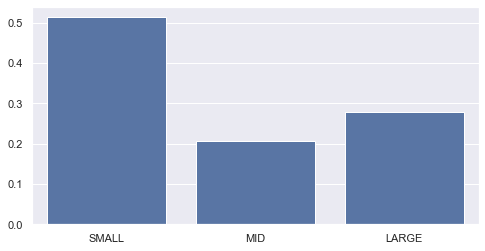

In [24]:
L = len(best_pred)
df_results = (best_pred.sum(axis=0) / L).rename('Best_prediction')
df_results = df_results.reset_index()
df_results = df_results.melt(id_vars='index', var_name='strategie', value_name='frequence')

fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(data=df_results, x='index', y='frequence', hue='strategie')
ax.get_legend().remove()
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.show()

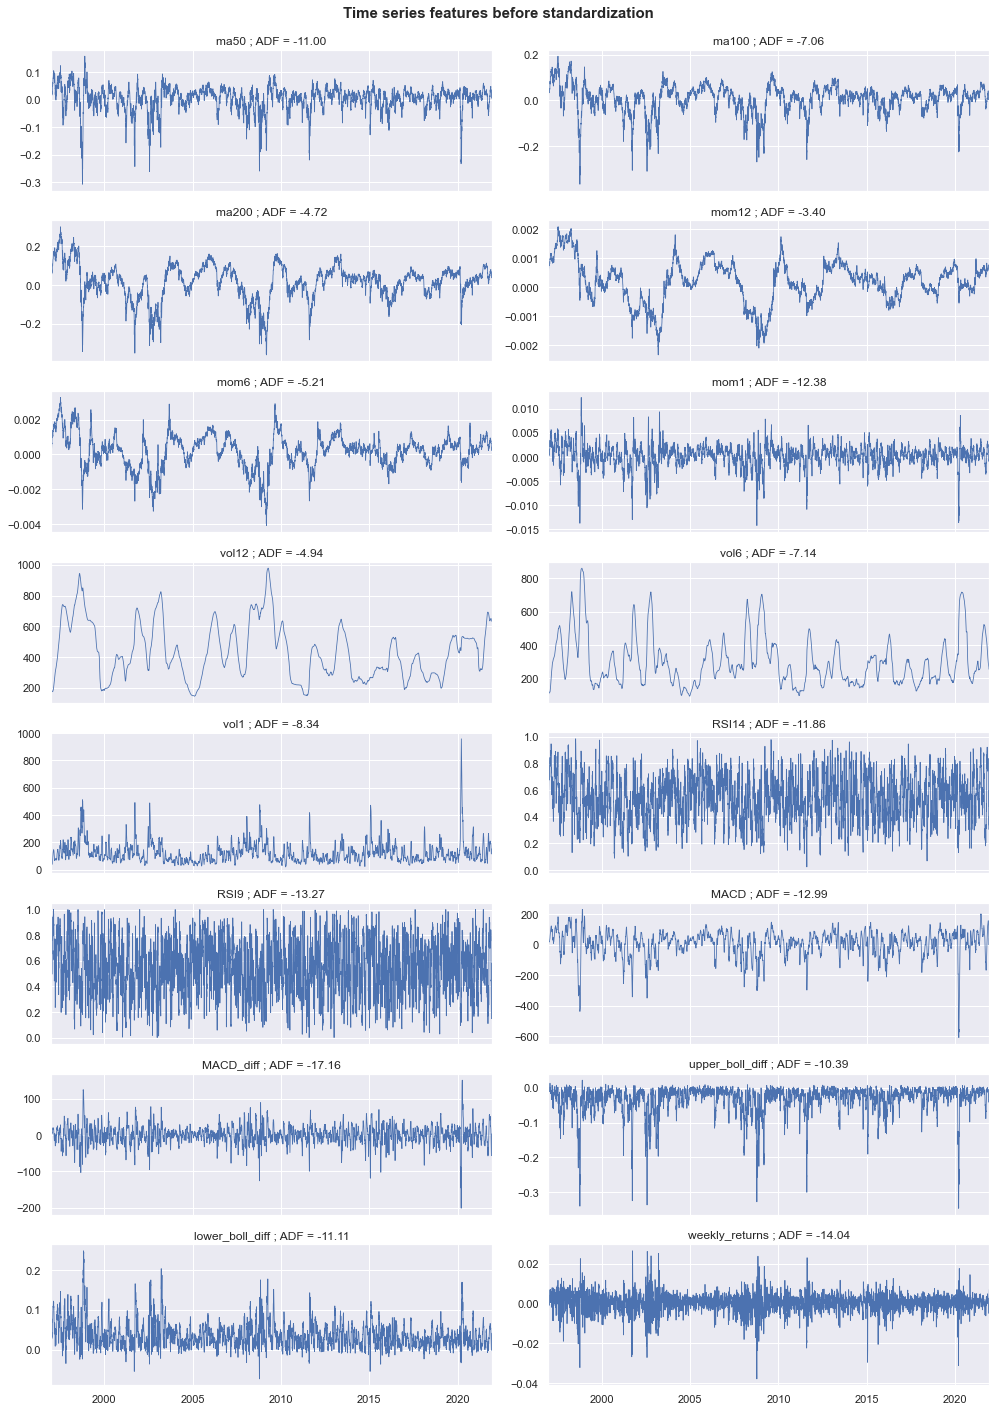

In [25]:
data_plot = df_X.iloc[:, df_X.columns.get_level_values(0) == 'MID']
data_plot.columns = data_plot.columns.get_level_values(1)

number_feature = len(data_plot.columns)
fig, axs = plt.subplots(number_feature // 2 + (number_feature % 2 > 0), 2, figsize=(14, 20), sharex=True)
axs = axs.ravel()
for i, col in enumerate(data_plot.columns):
    results = adfuller(data_plot[col].values)
    data_plot[col].plot(ax=axs[i], lw=0.8)
    axs[i].set_title(col + f' ; ADF = {results[0]:.2f}')
    
plt.suptitle('Time series features before standardization (MID CAP)', fontsize=15, fontweight='bold')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

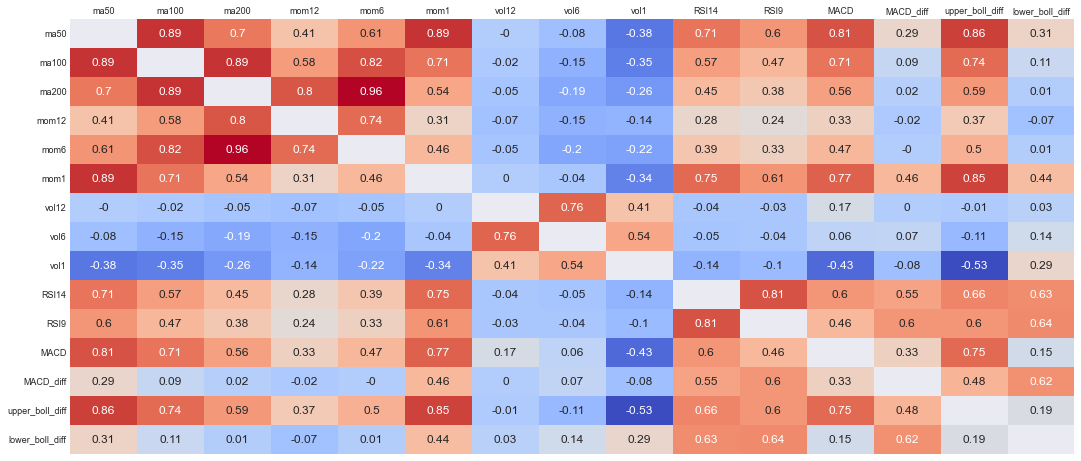

In [10]:
corr = data_plot.corr().round(2)

fig, ax = plt.subplots(figsize=(18,8))
mask = np.identity(len(corr))
sns.heatmap(data=corr, annot=True, cmap='coolwarm', cbar=False, mask=mask, annot_kws=dict(size=12))
ax.tick_params(axis='both', which='major', labelsize=9, labelbottom=False, labeltop=True, length=0)
plt.show()